#### RNN Class Definition

In [49]:
SAMPLE_RATE = 60  # Sampling rate in Hz
SEQ_LEN = 8 * SAMPLE_RATE  # Number of time steps (6 seconds with 60 Hz sampling)
MEAN_DURATION = 0.5  # Mean of exponential distribution (in seconds)
TIME_STEPS = SEQ_LEN  # Total time steps in the trial

WAIT_TIMES = {0.0:7.0, 0.2:5.0, 0.8:3.0, 1.0:1.0}

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

#### Network Implementation

In [45]:
class MDN_RNN(nn.Module):
    def __init__(self, hidden_size, input_size=1, output_size=3, num_gaussians=2):
        super(MDN_RNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.num_gaussians = num_gaussians
        
        # Recurrent Layers
        self.w = nn.Linear(in_features=self.input_size, out_features=self.hidden_size)
        self.rnn = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=1, batch_first=True) # dropout=0.1

        # Mixture Density Output Layers
        self.pi = nn.Linear(in_features=self.hidden_size, out_features=self.num_gaussians) # Mixture coefficients
        self.mu = nn.Linear(in_features=self.hidden_size, out_features=self.output_size * self.num_gaussians) # Means (outputs)
        self.sigma = nn.Linear(in_features=self.hidden_size, out_features=self.output_size * self.num_gaussians) # Std Dev (uncertainties)

        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=2)
        self.dropout = nn.Dropout(p=0.2)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if 'weight' in name:
                    nn.init.orthogonal_(param)

    def forward(self, x):
        # Recurrent Layer Output
        x = x.unsqueeze(-1)

        layer_1 = self.tanh(self.w(x).squeeze(-1))
        h, _ = self.rnn(layer_1)

        # Mixture Density Output Layers
        pi = nn.functional.softmax(self.pi(h).view(h.size(0), h.size(1), self.num_gaussians), dim=-1)
        
        mu = self.mu(h).view(h.size(0), h.size(1), self.output_size, self.num_gaussians)
        mu = nn.functional.softmax(mu, dim=-2)  # Softmax over state components (accumulation, accept, reject)
        
        sigma = torch.exp(torch.clamp(self.sigma(h).view(h.size(0), h.size(1), self.output_size, self.num_gaussians), min=-100, max=100))
        sigma = nn.functional.softplus(sigma)

        return pi, mu, sigma


In [33]:
def mdn_loss(pi, mu, sigma, targets):
    targets = targets.unsqueeze(-1).expand_as(mu)  # Match shape for mixture components

    pi = pi.unsqueeze(-2).expand_as(mu) # Reshape pi to use the same mixing coefficients for all outputs

    dist = torch.distributions.Normal(mu, sigma)

    likelihood = torch.exp(dist.log_prob(targets))  # Probability density

    weighted_likelihood = torch.sum(pi * likelihood, dim=-1)

    loss = -torch.log(weighted_likelihood).mean()  # Negative log-likelihood

    return loss

#### Training Data

In [52]:
def sigmoid_time_series(seq_len=30, center=15, width=10):
    # Create a time index array from 0 to seq_len-1.
    t = np.arange(seq_len)
    # Calculate the sigmoid function. The factor 4 ensures that the transition occurs
    # roughly over an interval of `width` time steps.
    sigmoid_values = 1 / (1 + np.exp(-4 * (t - center) / width))
    return sigmoid_values

class TrialDataset(Dataset):
    def __init__(self, num_samples, seq_len=SEQ_LEN, sample_rate=SAMPLE_RATE, mean_duration=MEAN_DURATION):
        self.num_samples = num_samples
        self.seq_len = seq_len
        self.sample_rate = sample_rate
        self.mean_duration = mean_duration

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Determine the decision time ~Exp(MEAN_DURATION)
        decision_time = int(np.random.exponential(self.mean_duration) * self.sample_rate) + 20
        decision_time += np.random.randint(-5, 5)
        decision_time = np.clip(decision_time, 0, self.seq_len) # increase variability in training 

        ### Generate input probability p and input sequence ###
        p = 0
        p = np.random.choice([0.0, 0.2, 0.8, 1.0])

        # Create target decision
        decision = 0
        if np.random.rand() <= p:
            decision = 1
        
        time = np.arange(self.seq_len) / self.sample_rate  # Time array in seconds

        inputs = np.full(self.seq_len, p - 0.5)

        ### Create outputs ###
        evidence_accumulation, accept, reject = np.zeros(self.seq_len), np.zeros(self.seq_len), np.zeros(self.seq_len)

        sigmoid_time_segment = sigmoid_time_series()
        
        if decision == 1:
            # gamma parameters: shape = (mean ** 2) / variance, scale = variance / mean
            wait_time = int((WAIT_TIMES[p] + np.random.gamma((0.1 ** 2) / 0.05, 0.05 / 0.1 )) * self.sample_rate)
            end_trial = min(wait_time + decision_time, self.seq_len - 30)

            evidence_accumulation[:decision_time - 15] = 1
            evidence_accumulation[decision_time - 15: decision_time + 15] = sigmoid_time_segment[::-1]
            accept[decision_time - 15: decision_time + 15] = sigmoid_time_segment
            accept[decision_time + 15:end_trial - 15] = 1
            accept[end_trial - 15: end_trial + 15] = sigmoid_time_segment[::-1]
            reject[end_trial - 15: end_trial + 15] = sigmoid_time_segment
            reject[end_trial + 15:] = 1
        else:
            evidence_accumulation[:decision_time - 15] = 1
            evidence_accumulation[decision_time - 15: decision_time + 15] = sigmoid_time_segment[::-1]
            reject[decision_time - 15: decision_time + 15] = sigmoid_time_segment
            reject[decision_time + 15:] = 1

        target_outputs = np.stack((evidence_accumulation, accept, reject), axis=1)

        # Convert to PyTorch tensors
        inputs = torch.tensor(inputs, dtype=torch.float32)
        targets = torch.tensor(target_outputs, dtype=torch.float32)
        
        return inputs, targets


#### Training Pass

In [53]:
LEARNING_RATE = 0.001
HIDDEN_SIZE = 512
NUM_EPOCHS = 100
BATCH_SIZE = 16
NUM_TRIALS = NUM_EPOCHS * BATCH_SIZE * 2

model = MDN_RNN(HIDDEN_SIZE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(0.99, 0.999), weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

dataset = TrialDataset(num_samples=NUM_TRIALS)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)

    for inputs, targets in progress_bar: #dataloader
        optimizer.zero_grad()

        # Forward Pass
        pi, mu, sigma = model(inputs)
        loss = mdn_loss(pi, mu, sigma, targets)
        
        # Backward Pass
        loss.backward()
        
        # Optimization Step
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}, Loss: {epoch_loss / len(dataloader):.4f}")

torch.save(model.state_dict(), 'model_weights_5.pth')

print("Training Complete!")

Epoch 1/100, Loss: 0.6835


Epoch 2/100, Loss: 0.6438


Epoch 3/100, Loss: 0.6275


Epoch 4/100, Loss: 0.6260


Epoch 5/100, Loss: 0.6150


Epoch 6/100, Loss: 0.6135


Epoch 7/100, Loss: 0.6105


Epoch 8/100, Loss: 0.6086


Epoch 9/100, Loss: 0.6107


Epoch 10/100, Loss: 0.6106


Epoch 11/100, Loss: 0.6073


Epoch 12/100, Loss: 0.6103


Epoch 13/100, Loss: 0.6120


Epoch 14/100, Loss: 0.6143


Epoch 15/100, Loss: 0.6110


Epoch 16/100, Loss: 0.6060


Epoch 17/100, Loss: 0.6091


Epoch 18/100, Loss: 0.6071


Epoch 19/100, Loss: 0.6085


Epoch 20/100, Loss: 0.6089


Epoch 21/100, Loss: 0.6110


Epoch 22/100, Loss: 0.6072


Epoch 23/100, Loss: 0.6109


Epoch 24/100, Loss: 0.6076


Epoch 25/100, Loss: 0.6076


Epoch 26/100, Loss: 0.6085


Epoch 27/100, Loss: 0.6112


Epoch 28/100, Loss: 0.6068


Epoch 29/100, Loss: 0.6088


Epoch 30/100, Loss: 0.6115


Epoch 31/100, Loss: 0.6084


Epoch 32/100, Loss: 0.6092


Epoch 33/100, Loss: 0.6095


Epoch 34/100, Loss: 0.6091


Epoch 35/100, Loss: 0.6083


Epoch 36/100, Loss: 0.6065


Epoch 37/100, Loss: 0.6123


Epoch 38/100, Loss: 0.6108


Epoch 39/100, Loss: 0.6059


Epoch 40/100, Loss: 0.6097


Epoch 41/100, Loss: 0.6083


Epoch 42/100, Loss: 0.6046


Epoch 43/100, Loss: 0.6065


Epoch 44/100, Loss: 0.6061


Epoch 45/100, Loss: 0.6053


Epoch 46/100, Loss: 0.6092


Epoch 47/100, Loss: 0.6083


Epoch 48/100, Loss: 0.6120


Epoch 49/100, Loss: 0.6063


Epoch 50/100, Loss: 0.6073


Epoch 51/100, Loss: 0.6066


Epoch 52/100, Loss: 0.6060


Epoch 53/100, Loss: 0.6093


Epoch 54/100, Loss: 0.6066


Epoch 55/100, Loss: 0.6088


Epoch 56/100, Loss: 0.6064


Epoch 57/100, Loss: 0.6099


Epoch 58/100, Loss: 0.6064


Epoch 59/100, Loss: 0.6061


Epoch 60/100, Loss: 0.6065


Epoch 61/100, Loss: 0.6055


Epoch 62/100, Loss: 0.6068


Epoch 63/100, Loss: 0.6074


Epoch 64/100, Loss: 0.6067


Epoch 65/100, Loss: 0.6077


Epoch 66/100, Loss: 0.6042


Epoch 67/100, Loss: 0.6076


Epoch 68/100, Loss: 0.6072


Epoch 69/100, Loss: 0.6066


Epoch 70/100, Loss: 0.6041


Epoch 71/100, Loss: 0.6072


Epoch 72/100, Loss: 0.6069


Epoch 73/100, Loss: 0.6051


Epoch 74/100, Loss: 0.6058


Epoch 75/100, Loss: 0.6069


Epoch 76/100, Loss: 0.6059


Epoch 77/100, Loss: 0.6091


Epoch 78/100, Loss: 0.6080


Epoch 79/100, Loss: 0.6074


Epoch 80/100, Loss: 0.6052


Epoch 81/100, Loss: 0.6064


Epoch 82/100, Loss: 0.6052


Epoch 83/100, Loss: 0.6060


Epoch 84/100, Loss: 0.6047


Epoch 85/100, Loss: 0.6075


Epoch 86/100, Loss: 0.6048


Epoch 87/100, Loss: 0.6037


Epoch 88/100, Loss: 0.6069


Epoch 89/100, Loss: 0.6051


Epoch 90/100, Loss: 0.6075


Epoch 91/100, Loss: 0.6060


Epoch 92/100, Loss: 0.6060


Epoch 93/100, Loss: 0.6059


Epoch 94/100, Loss: 0.6038


Epoch 95/100, Loss: 0.6066


Epoch 96/100, Loss: 0.6067


Epoch 97/100, Loss: 0.6081


Epoch 98/100, Loss: 0.6065


Epoch 99/100, Loss: 0.6058


Epoch 100/100, Loss: 0.6043
Training Complete!


#### Load Model

In [ ]:
model = RNN(HIDDEN_SIZE)
model.load_state_dict(torch.load('model_weights_5.pth', weights_only=True))

<All keys matched successfully>

#### Test Model Performance

In [54]:
dataset = TrialDataset(num_samples=NUM_TRIALS)

def visualize_performance():
    # Select a random sample from the dataset
    sample_idx = np.random.randint(0, len(dataset))
    inputs, targets = dataset[sample_idx]
    inputs = inputs.unsqueeze(0)

    # Forward pass through the MDN_RNN
    pi, mu, sigma = model(inputs)

    # Remove batch dimension and convert to numpy
    pi = pi.unsqueeze(-2).expand_as(mu)
    pi = pi.squeeze(0).detach().numpy()  # Shape: (SEQ_LEN, num_states, num_gaussians)
    mu = mu.squeeze(0).detach().numpy()  # Shape: (SEQ_LEN, num_states, num_gaussians)
    sigma = sigma.squeeze(0).detach().numpy()  # Shape: (SEQ_LEN, num_states, num_gaussians)

    # Compute weighted mean over the mixture components for each output
    weighted_mu = np.sum(pi * mu, axis=-1)  # Shape: (SEQ_LEN, num_states)
    weighted_sigma = np.sqrt(np.sum(pi * (sigma**2 + mu**2), axis=-1) - weighted_mu**2)  # Law of total variance

    # Generate time array
    time = np.arange(SEQ_LEN) / SAMPLE_RATE

    plt.figure(figsize=(12, 12))

    # Plot input signals
    plt.subplot(5, 1, 1)
    plt.plot(time, inputs.squeeze().numpy(), label='Input', color='red', linestyle='dotted')
    plt.ylim(-0.7, 0.7)
    plt.legend()

    # Plot target outputs vs predicted weighted mean
    labels = ['Evidence Accumulation', 'Accept', 'Reject']
    colors = ['orange', 'green', 'red']

    for i in range(3):
        plt.subplot(5, 1, i + 2)
        plt.plot(time, weighted_mu[:, i], label=f'{labels[i]} (Predicted)', color=colors[i])
        plt.fill_between(time, 
                         weighted_mu[:, i] - weighted_sigma[:, i], 
                         weighted_mu[:, i] + weighted_sigma[:, i], 
                         color=colors[i], alpha=0.3)
        plt.plot(time, targets[:, i].numpy(), label=f'{labels[i]} (True)', color='black', linestyle='dotted')
        plt.ylim(-1, 2)
        plt.legend()

    plt.xlabel("Time (s)")
    plt.show()


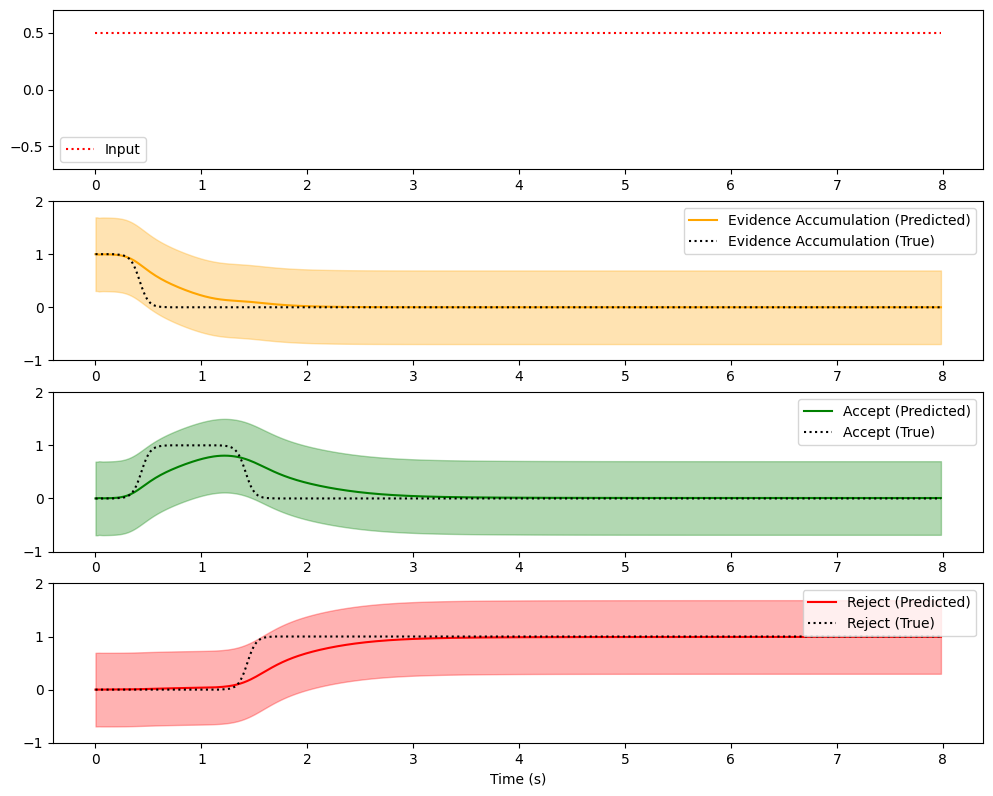

In [62]:
visualize_performance()

In [ ]:
dataset = TrialDataset(num_samples=1000, mode='full')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

total_trials = [0, 0, 0, 0]         # [0%, 20%, 80%, 100%]
total_accepts_data = [0, 0, 0, 0]   # [0%, 20%, 80%, 100%]
total_accepts_model = [0, 0, 0, 0]  # [0%, 20%, 80%, 100%]
peak_time_data = []
peak_time_model = []

for i in range(1000):
    inputs, target = next(iter(dataloader))
    f = model(inputs)

    trial_type_idx = 0

    if inputs[0].numpy()[0] == -0.5:
        trial_type_idx = 0
    elif inputs[0].numpy()[0] > -0.4 and inputs[0].numpy()[0] < -0.1:
        trial_type_idx = 1
    elif inputs[0].numpy()[0] > 0.1 and inputs[0].numpy()[0] < 0.4:
        trial_type_idx = 2
    elif inputs[0].numpy()[0] == 0.5:
        trial_type_idx = 3

    total_trials[trial_type_idx] += 1
    
    data_accept, model_accept = False, False

    if np.mean(target[0].numpy()) > 0.5:
        data_accept = True 
    if np.mean(f[0].detach().numpy()) > 0:
        model_accept = True 

    data_peak, model_peak = 0, 0

    if data_accept:
        total_accepts_data[trial_type_idx] += 1
        data_peak = np.argmax(target[0].numpy())
    elif not data_accept:
        data_peak = np.argmin(target[0].numpy())
    
    if model_accept:
        total_accepts_model[trial_type_idx] += 1
        model_peak = np.argmax(f[0].detach().numpy())
    elif not model_accept:
        model_peak = np.argmin(f[0].detach().numpy())

    peak_time_data.append(data_peak / SAMPLE_RATE)
    peak_time_model.append(model_peak / SAMPLE_RATE)
    
print("Data Accept Percentages: ", np.divide(total_accepts_data, total_trials))
print("Model Accept Percentages: ", np.divide(total_accepts_model, total_trials))

bins = np.linspace(0, 4, 40)
plt.figure()
plt.subplot(2, 1, 1)
plt.hist(peak_time_model, bins, label='Model Accept Time Distribution')
plt.legend(loc='upper right')
plt.subplot(2, 1, 2)
plt.hist(peak_time_data, bins, label='Data Accept Time Distribution')
plt.legend(loc='upper right')
plt.show()


#### Visualize Training Data

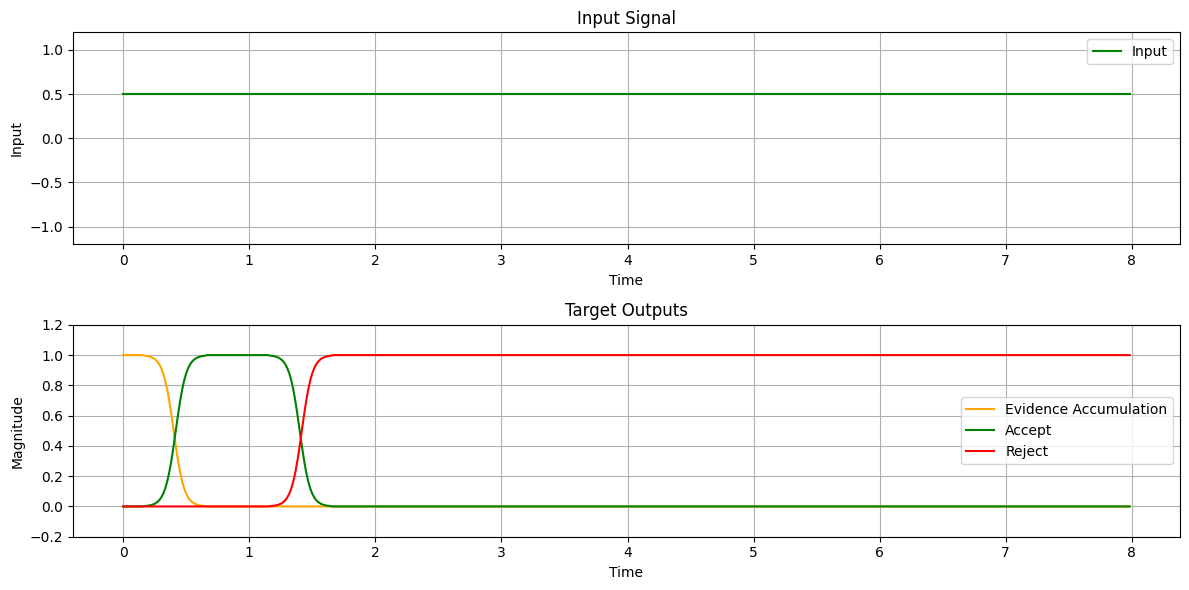

In [28]:
import matplotlib.pyplot as plt

NUM_EPOCHS = 100
BATCH_SIZE = 16
NUM_TRIALS = NUM_EPOCHS * BATCH_SIZE * 2

def plot_trial():
    """
    Plot the input signal and target outputs for a single trial.
    """
    dataset = TrialDataset(num_samples=NUM_TRIALS)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    sample_idx = np.round(np.random.randint(0, len(dataset) + 1))
    
    inputs, target_outputs = dataset[sample_idx]

    time = np.arange(len(inputs)) / SAMPLE_RATE  # Convert to seconds
    
    plt.figure(figsize=(12, 6))
    
    # Plot input
    plt.subplot(2, 1, 1)
    plt.plot(time, inputs.numpy(), color='green', label='Input')
    plt.title("Input Signal")
    plt.xlabel("Time")
    plt.ylabel("Input")
    plt.ylim(-1.2, 1.2)
    plt.grid(True)
    plt.legend()
    
    # Plot target output
    plt.subplot(2, 1, 2)
    plt.plot(time, target_outputs[:, 0].numpy(), color='orange', label='Evidence Accumulation')
    plt.plot(time, target_outputs[:, 1].numpy(), color='green', label='Accept')
    plt.plot(time, target_outputs[:, 2].numpy(), color='red', label='Reject')
    plt.title("Target Outputs")
    plt.xlabel("Time")
    plt.ylabel("Magnitude")
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the trial
plot_trial()
